### Data Science Case Study - 
- Codes to download and  extract the data for "geological_similarity"
- problem link provided in file: 'Data Science Case Study Options 1.0.pdf' 
- Option 2: Geological Image Similarity
- Repository page: https://github.com/shantanuneema/geo_image_problem

#### Prepared by: Shantanu Neema (Cummins Inc.)
#### Chosen name of the tool: GI-Similarity

#### Introduction
This notebook documents and summarizes a tool for identifying interesting patterns in their imagery data for igneous and metamorphic thin sections for 6 types of rocks. The tool has search capability whereby an minerologist will provide an image of interest and will be presented with other images which are similr to it. The user will have a choice to select how many most similar images are desired.

Data Source: http://aws-proserve-data-science.s3.amazonaws.com/geological_similarity.zip

#### Purpose
The purpose of this work is to help analyst like geologist or minerologist to find similar images from a labelled thin section microscopic image dataset by showing top similar images to the input image

#### Scope
The functional requirements of this tool (GI-Similarity) is to help analyst to find similar images from a labelled image dataset. End user should be able to gain insights from the outputs of the most similar images to the one chosen by them. A machine learning component starts from scrate and load data, restructure it and develop a model for this image similarity application. The model is expected to return the top K images that are most similar to the image based on a single image input.

#### Tools and Techniques

Language : Python 3.6.5 <br>
Packages Used :

1. fastai 1.0.55
2. ipython 7.6.1
3. torch 1.1.0
4. matplotlib 3.1.1
5. split_data_folder* 
6. lshash 1.0
7. tqdm 4.32.2
8. torchvision 0.3.0
9. BitVector 3.4.9
10. requests 2.22.0
11. PIL 6.1.0
12. zipfile

Platform : Linux

*modified as needed from - https://github.com/jfilter/split-folders

#### Deployment

- The user is exected to use this notebook in linux platform to work
- Data will be automatically loaded from the url for the first time user
- The data will be stored and be present for future runs in the folder path

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard ipynb magics for plotting and for automatic reload for the libraries

### Load/Download the data and restructure as train, test and validation folders
- Data downloaded and stored from the provided aws link  
- Subfolders name shall be used as image labels

--------------------------------------------------
1. CLEAN AND CONFIGURE THE INPUT GEOLOGICAL IMAGE DATA
Data is stored in /home/pr916/notebooks/geo_image_problem
geological image data loaded
6 classes are:
      ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
Train dataset size: 23998 images
Test dataset size: 2999 images
Given data with labels as shown below:


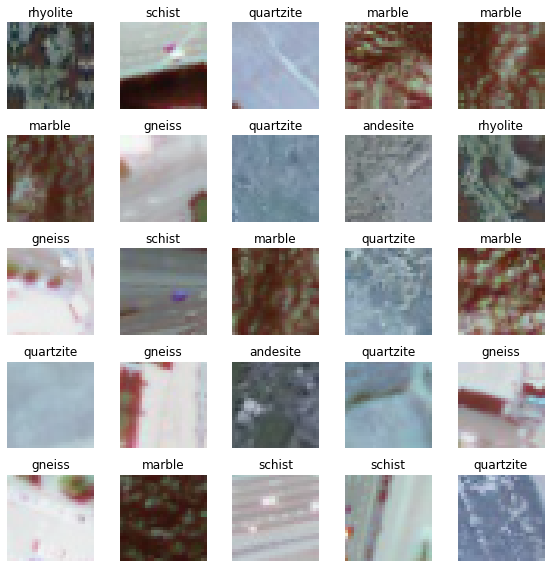

In [2]:
import os
import sys
import pathlib

# Make use of fastai library for computer vision applications
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from PIL import Image
from tqdm import tqdm_notebook

#fine grain classification problem
# Desired data folders as train, test and validation set for each label image

working_folder = str(pathlib.Path.cwd().parent) + '/src/'
os.chdir(working_folder)

import split_data_folder 
import GI_config as conf_lib
import GI_lib as lib

%run GI_main.py 

print('Given data with labels as shown below:')
geo_data.show_batch(rows=5, figsize=(8,8))

### Training a CNN model using 80% of the images
- Using the pretrained weights resnet34 model (transfer learning)
reference: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

In [3]:
## Creating the model by chosing resnet34 architecture
arch = models.resnet34
learn = cnn_learner(geo_data, arch, pretrained=True, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.51E-02


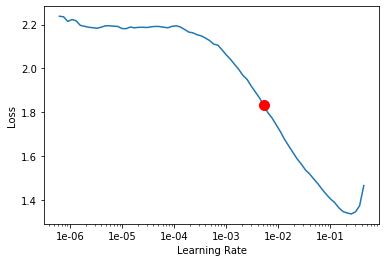

In [4]:
# Finding Ideal learning rate using learning rate finder (fast ai library)
# Reference: 
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_0 = learn.recorder.min_grad_lr

#### LR Finder indication:
- We choose a value that is approximately in the middle of the sharpest downward slope
- Let's for the minimum suggested numerical gradient with 2 epochs

In [6]:
print('train using suggested minimum numerical gradient:', lib.format_decimal(min_grad_0))
learn.fit_one_cycle(2, min_grad_0)
print('saving the model under', conf_lib.image_folder + '/models/')

train using suggested minimum numerical gradient: 5.24e-3


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.182775,0.092199,0.967656,0.032344,01:56
1,0.115308,0.065558,0.975659,0.024341,01:55


saving the model under /home/pr916/notebooks/geo_image_problem/geological_similarity//models/


In [7]:
## Saving stage 1
learn.save('model1-rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.02E-06


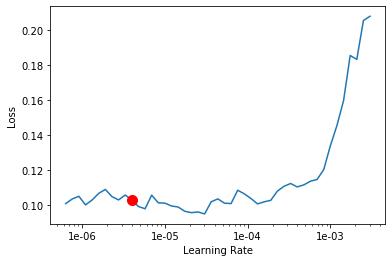

In [8]:
## Unfreeing layer and finding ideal learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_1 = learn.recorder.min_grad_lr

In [9]:
# Fitting 5 epochs and use a range of 1/10th of suggested gradient and the gradient calculated above
# ARule of thumb by Jeremy Howard (Developer of fast ai library)

learn.fit_one_cycle(5, slice(min_grad_1, min_grad_0/10))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.089651,0.059930,0.978326,0.021674,05:02
1,0.100963,0.057852,0.979660,0.020340,04:59
2,0.077976,0.046757,0.985662,0.014338,04:51
3,0.068944,0.038362,0.986996,0.013004,04:49
4,0.062665,0.045012,0.983328,0.016672,04:52


In [11]:
## Saving model weights
learn.save('model2-unfreeze')

In [46]:
learn.interpret().most_confused(min_val=2)

[('quartzite', 'andesite', 30),
 ('andesite', 'rhyolite', 7),
 ('gneiss', 'schist', 6),
 ('rhyolite', 'andesite', 4),
 ('schist', 'gneiss', 3)]

In [47]:
df_cm = pd.DataFrame(interp.confusion_matrix(), 
                     index = geo_data.classes,
                     columns = geo_data.classes)

df_cm

,andesite,gneiss,marble,quartzite,rhyolite,schist
andesite,493,0,0,0,7,0
gneiss,0,494,0,0,0,6
marble,0,0,499,0,0,0
quartzite,30,0,0,470,0,0
rhyolite,4,0,0,0,496,0
schist,0,3,0,0,0,497


In [48]:
ar_cm = interp.confusion_matrix()
print('Test accuracy: ' ,round(np.trace(ar_cm)*100/np.sum(ar_cm)),2,'%',sep='')

Test accuracy: 98.02%


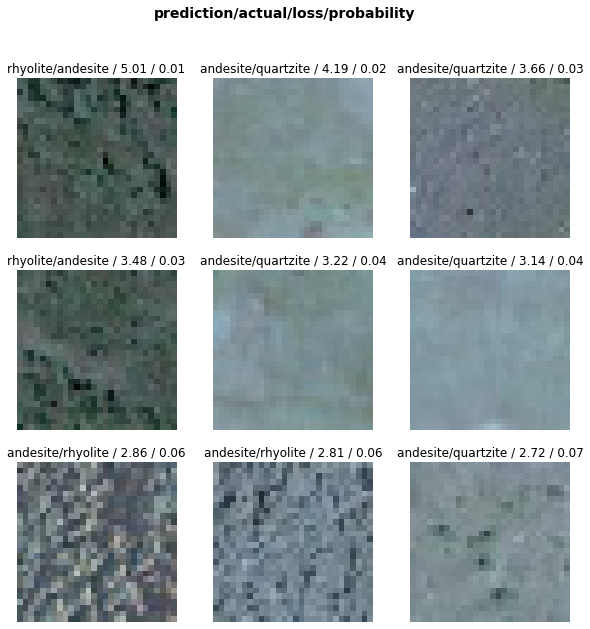

In [45]:
learn.interpret().plot_top_losses(9, figsize=(10,10))

In [12]:
# Hook (refer: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [13]:
sf = SaveFeatures(learn.model[1][5])

In [14]:
_= learn.get_preds(geo_data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [15]:
img_path = [str(x) for x in (list(geo_data.train_ds.items)+list(geo_data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [16]:
path = pathlib.Path(conf_lib.image_folder)

In [17]:
## Exporting as pickle
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

In [18]:
from lshash import LSHash

In [20]:
## Locality Sensitive Hashing
# params
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

In [21]:
# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [22]:
pickle.dump(lsh, open(path/'lsh.p', "wb"))

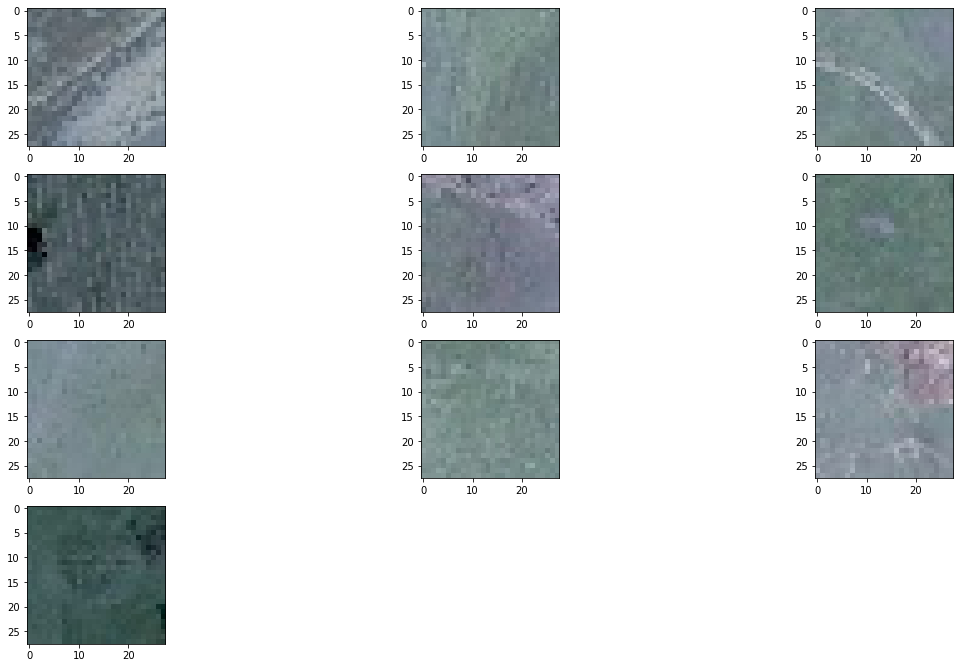

In [24]:
get_similar_item(0, feature_dict, lsh, 9)